In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, plot_confusion_matrix, precision_score, recall_score
from sklearn.linear_model import LogisticRegression

from scipy.stats import chisquare

## Данные

Переменные, характеризующие кредитную историю клиента
- closed_cred_sum - сумма, которую клиент выплатил по ранее взятым и закрытым кредитам
- closed_creds - количество закрытых кредитов
- active_cred_sum_overdue - суммарная задолженность по активным кредитам
- active_cred_sum - сумма всех активных кредитов
- active_cred_day_overdue - суммарная просрочка в днях по всем активным кредитам
- active_cred_max_overdue - максимальная сумма просроченной задолженности по активным кредитам

Переменные характеризующие клиента
- age - возраст
- gender - пол
- region - регион
- month_income - ежемесячный доход

Переменные, характеризующие кредит, по которому нужно сделать прогноз
- first_loan - сумма, которую клиент хочет получить в кредит (из заявки)
- first_days_quant - срок, на которую клиент хочет взять кредит
- loan_cost_all - одобренная клиенту сумма кредита
- order_date - дата подачи заявки на получение кредита
- cost_all - сумма всех выплат по одобренному кредиту
- order_id - id заявки
- client_id - id клиента

Целевая переменная:
- expert - решение, которое принято по заявке (0 - одобрено, 1 - отклонено)

Задача: построить модель для предсказания целевой переменной

## Фильтрация

In [2]:
df = pd.read_csv('data.csv', delimiter=';')
df.shape

(50001, 18)

In [3]:
df.head()

,closed_cred_sum,closed_creds,active_cred_sum_overdue,active_cred_sum,active_cred_day_overdue,active_cred_max_overdue,age,gender,region,first_loan,loan_cost_all,first_days_quant,month_income,order_date,cost_all,order_id,client_id,expert
0,143822.0,22,104.12,130068.80,8,756.09,31,0,36,10000.0,10000,196,0.0,2017-07-23,0.0,728319,320464,1
1,0.0,0,38151.93,46230.00,1492,38151.93,51,0,93,10000.0,10000,17,20000.0,2017-07-23,0.0,728321,320466,1
2,51356.0,2,3000.00,3000.00,8,3000.00,28,1,3,10000.0,10000,84,0.0,2017-07-23,0.0,728323,320467,1
3,0.0,0,22784.19,32103.52,913,22784.19,28,0,52,10000.0,10000,7,0.0,2017-07-23,0.0,728447,320533,1
4,12298.0,1,4942.95,4950.00,2883,4942.95,31,0,47,5000.0,5000,20,0.0,2017-07-23,0.0,728421,298598,1


In [4]:
df.isnull().sum()

closed_cred_sum             0
closed_creds                0
active_cred_sum_overdue     0
active_cred_sum             0
active_cred_day_overdue     0
active_cred_max_overdue     0
age                         0
gender                      0
region                      0
first_loan                 19
loan_cost_all               0
first_days_quant            0
month_income                0
order_date                  0
cost_all                    0
order_id                    0
client_id                   0
expert                      0
dtype: int64

В данных всего 19 пропущенных значений по переменной first_loan, можно удалить их из выборки.

In [5]:
# удалим наблюдения с пропущенными значениями
df.dropna(inplace=True)

Некоторые переменные можно убрать из выборки, так как они очевидно не несут смысла и могут ухудшить качество прогноз.

#### Order_id

Перед удалением order_id проверим, нет ли каких-то странностей с этой переменной.

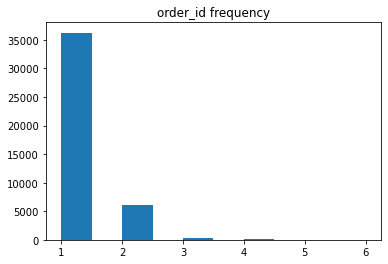

In [6]:
df.groupby('order_id').order_id.count().sort_values().hist(grid=0)
plt.title('order_id frequency')
plt.show()

Некоторые значения order_id встречаются больше одного раза. Это странно, ведь номер заявки должен быть уникальным.

In [7]:
# количество дубликатов
df[df.duplicated(keep=False)].shape[0]

13554

Оказывается, в данных есть полные дубликаты. Они негативно влияют на качество модели, поэтому удаляем.

In [8]:
# удалим дубликаты
df.drop_duplicates(inplace=True)

# количество дубликатов по order_id
id_count = df.groupby('order_id').order_id.count()
duplicate_index = id_count.where(id_count > 1).dropna().index
df[df.order_id.isin(duplicate_index)].shape[0]

172

После удаления дубликатов осталось несколько переменных. Получается, что некоторые наблюдения имеют одинаковые order_id, но различные значения других переменных.

In [9]:
# максимальное количество одинаковых order_id
id_count.max()

2

In [10]:
df[df.order_id.isin(duplicate_index)].head(6)

,closed_cred_sum,closed_creds,active_cred_sum_overdue,active_cred_sum,active_cred_day_overdue,active_cred_max_overdue,age,gender,region,first_loan,loan_cost_all,first_days_quant,month_income,order_date,cost_all,order_id,client_id,expert
1227,137132.0,9,0.0,1500.00,0,0.0,28,0,11,5000.0,5000,56,0.0,2017-09-23,0.0,826660,381507,1
1228,137132.0,9,0.0,0.00,0,0.0,28,0,11,5000.0,5000,56,0.0,2017-09-23,0.0,826660,381507,1
1286,51000.0,3,0.0,219000.00,0,9749.5,48,1,77,3000.0,3000,21,0.0,2017-09-23,0.0,827110,381901,1
1287,51000.0,3,0.0,219000.00,0,9749.5,48,1,45,3000.0,3000,21,0.0,2017-09-23,0.0,827110,381901,1
1307,0.0,0,0.0,16958.49,0,0.0,32,0,65,2000.0,2000,14,0.0,2017-09-23,0.0,827129,381917,1
1308,0.0,0,0.0,16958.49,0,0.0,32,0,80,2000.0,2000,14,0.0,2017-09-23,0.0,827129,381917,1


Судя по первым 6 наблюдениям, строки с одинаковыми order_id отличаются значениями только одной переменной. Скорее всего, одно из наблюдений было введено с ошибкой, а другое является его исправленной версией. Неизвестно, какое из двух корректно (можно предположить, что второе, потому что даты идут в порядке возрастания), поэтому удалим все.

In [11]:
df = df[~df.order_id.isin(duplicate_index)]
df.shape[0]

42754

Повторяющихся order_id в данных не осталось. Теперь можно удалить переменную, она не несет никакого смысла.

### client_id

Проверим client_id на наличие аномалий.

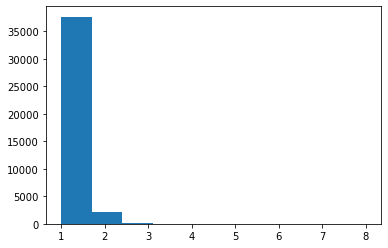

In [12]:
df.groupby('client_id').client_id.count().hist(grid=False)
plt.show()

Абсолютное большинство клиентов оставило одну заявку, но встречаются исключения (2-8 заявок).

In [13]:
# количество клиентов с двумя и более заявками
client_count = df.groupby('client_id').client_id.count()
client_index = client_count.where(client_count > 1).dropna().index
df[df.client_id.isin(client_index)].shape[0]

5095

In [14]:
one_order_mean = df[~df.client_id.isin(client_index)].expert.mean()
several_order_mean = df[df.client_id.isin(client_index)].expert.mean()

print('Средний процент отказов среди клиентов с двумя и более заявками:',
      round(several_order_mean, 3))
print('Средний процент отказов среди клиентов с одной заявкой:',
      round(one_order_mean, 3))

Средний процент отказов среди клиентов с двумя и более заявками: 0.374
Средний процент отказов среди клиентов с одной заявкой: 0.788


Клиенты с несколькими заявками значительно реже получают отказ. Возможно, клиенты успешно выплатившие кредит, чаще возвращаются за новым. И наоборот, клиенты, получившие отказ, реже подают новые заявки. Предположим, что количество поданных клиентом заявок не влияет на решение по кредиту и просто удалим переменную client_id.

### loan_cost_all

Судя по описанию, переменная указывает на одобренную сумму кредита и актуальна только для уже одобренных кредитов.

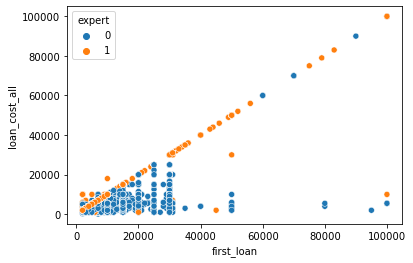

In [15]:
# связь между запрошенной и одобренной суммой кредита
sns.scatterplot(data=df, x='first_loan', y='loan_cost_all', hue='expert')
plt.show()

In [16]:
# средняя разница между запрошенной и одобренной суммой кредита
df.groupby('expert').apply(lambda x: np.mean(x.first_loan - x.loan_cost_all))

expert
0    4160.008937
1       7.666962
dtype: float64

Для отклоненных заявок переменные first_loan и loan_cost_all почти равны. Скорее всего, это просто специфика данных: для отказов в одобренную сумму (loan_cost_all) попадает сумма из заявки (first_loan). В таком случае правильнее было бы указывать 0 в loan_cost_all.

### cost_all

Как и в предыдущем случае, переменная имеет смысл только для одобренных кредитов, так как указывает на сумму выплат по кредиту.

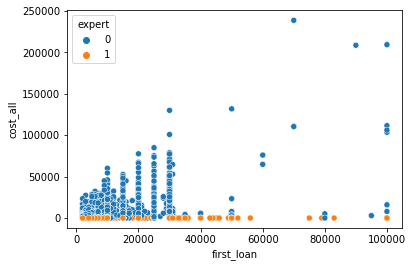

In [17]:
# связь между запрошенной суммой кредита и выплатами
sns.scatterplot(data=df, x='first_loan', y='cost_all', hue='expert')
plt.show()

In [18]:
# средняя разница между запрошенной суммой кредита и выплатами
df.groupby('expert').cost_all.mean()

expert
0    5003.555907
1       0.000000
Name: cost_all, dtype: float64

Для отклоненных заявок переменная cost_all всегда равна нулю.

### Связь между cost_all и loan_cost_all

In [19]:
# разница cost_all и loan_cost_all по группам
accepted = df.groupby('expert').apply(lambda x: x.cost_all - x.loan_cost_all)[0]
rejected = df.groupby('expert').apply(lambda x: x.cost_all - x.loan_cost_all)[1]

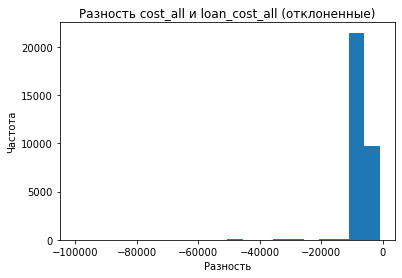

In [20]:
plt.hist(rejected, bins=20)
plt.title('Разность cost_all и loan_cost_all (отклоненные)')
plt.xlabel('Разность')
plt.ylabel('Частота')
plt.show()

Для отклоненных заявок аномалий нет. Сумма выплат по кредиту cost_all в этой группе всегда равна нулю, а значение loan_cost_all равно сумме из заявки.

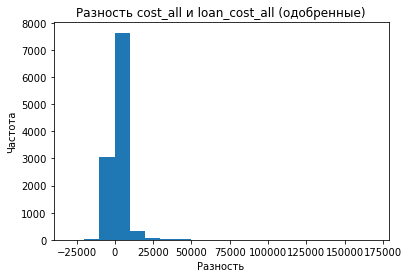

In [21]:
plt.hist(accepted, bins=20)
plt.title('Разность cost_all и loan_cost_all (одобренные)')
plt.xlabel('Разность')
plt.ylabel('Частота')
plt.show()

Для некоторых наблюдений разность cost_all и loan_cost_all отрицательна, то есть клиент выплатил меньше, чем взял.

In [22]:
df_cost_all_check = df.query('(cost_all < loan_cost_all) & (expert == 0)')
df_cost_all_check.head()

,closed_cred_sum,closed_creds,active_cred_sum_overdue,active_cred_sum,active_cred_day_overdue,active_cred_max_overdue,age,gender,region,first_loan,loan_cost_all,first_days_quant,month_income,order_date,cost_all,order_id,client_id,expert
5,786916.00,11,0.0,1063763.0,0,10395.39,47,0,38,10000.0,5500,14,50000.0,2017-07-23,0.0,728526,320564,0
27,10000.00,1,0.0,69993.0,0,0.00,28,0,19,10000.0,1000,23,50000.0,2017-07-23,0.0,728543,320571,0
37,44897.62,9,2000.0,25000.0,9,2000.00,35,0,0,2000.0,1500,20,50000.0,2017-07-23,0.0,728732,221966,0
38,17075.00,1,0.0,75044.0,0,3066.73,26,0,36,5000.0,2500,19,35000.0,2017-07-23,0.0,728735,320659,0
46,61000.00,5,6755.9,580001.0,41,12614.43,35,1,0,10000.0,3000,14,0.0,2017-07-24,0.0,729135,171238,0


Может быть три объяснения, почему у некоторых одобренных заявок значение cost_all равно нулю:
- Клиент взял кредит и не выплатил его
- Заявка была одобрена, но клиент не взял деньги
- Ошибка в данных

В первом случае можно заменить значение целевой переменной на 1, во втором - оставить наблюдения без каких-либо изменений, в третьем - удалить наблюдения из выборки.

In [23]:
df = df[~df.index.isin(df_cost_all_check.index)]

Поскольку реальная причина неизвестна, на всякий случай удалим наблюдения из выборки.

### order_date

Скорее всего, дата подачи заявки никак не влияет на решение, поэтому переменную можно удалить.

In [24]:
dt = pd.to_datetime(df.order_date)

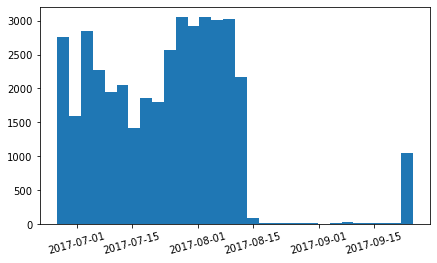

In [25]:
# распределение поданных заявок по дате
dt.hist(bins=30, grid=False, figsize=(7, 4))
plt.xticks(rotation=15)
plt.show()

После 15-08-2017 количество заявок упало почти до нуля. При предсказании целевой переменной это никак не поможет, но интересна причина такого распределения.

## Преобразование переменных

In [26]:
X = df.drop(columns={'client_id', 'order_id', 'cost_all', 'loan_cost_all', 'order_date', 'expert'})
y = df.expert

In [27]:
X.describe().round(2)

,closed_cred_sum,closed_creds,active_cred_sum_overdue,active_cred_sum,active_cred_day_overdue,active_cred_max_overdue,age,gender,region,first_loan,first_days_quant,month_income
count,39639.00,39639.00,39639.00,39639.00,39639.00,39639.00,39639.00,39639.00,39639.00,39639.00,39639.00,39639.00
mean,175319.19,7.62,51622.93,184437.73,733.21,37523.36,34.82,0.46,28.54,7610.16,24.58,24991.50
std,512804.53,13.81,253837.51,416956.35,1365.64,173989.00,11.24,0.50,29.76,5300.13,39.03,20607.67
min,0.00,0.00,0.00,0.00,0.00,0.00,18.00,0.00,0.00,2000.00,7.00,0.00
25%,4954.55,1.00,0.00,13000.00,0.00,602.63,27.00,0.00,0.00,5000.00,10.00,0.00
50%,37890.00,3.00,5385.94,52422.00,80.00,7000.00,32.00,0.00,24.00,7000.00,19.00,25000.00
75%,157883.44,9.00,32297.34,182361.92,938.00,24852.75,40.00,1.00,52.00,10000.00,20.00,35000.00
max,44574209.38,563.00,33030999.24,22731655.24,21927.00,21701655.24,99.00,1.00,99.00,100000.00,336.00,550000.00


Скорее всего, данные принадлежат микрофинансовой организации.
- Медианная сумма займа - 7 тыс.
- В 75% случаев срок выплаты не превышает 20 дней

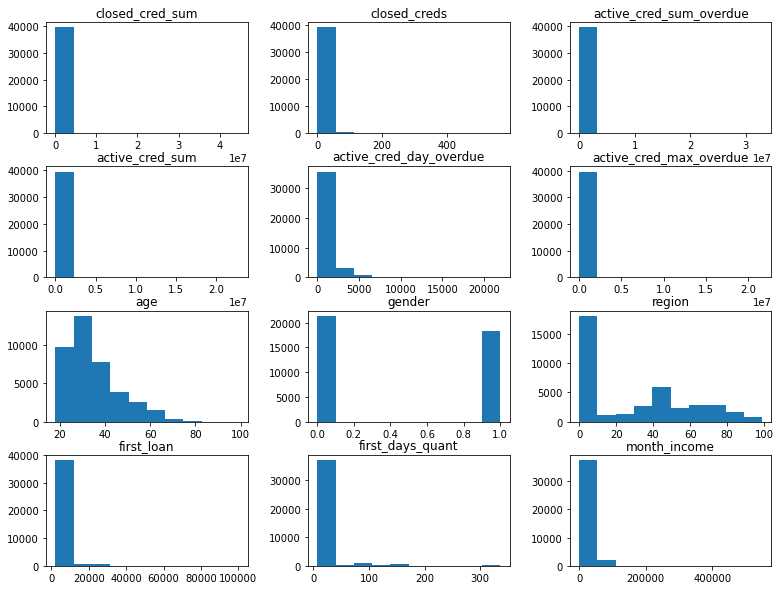

In [28]:
# распределение переменных
X.hist(figsize=(13, 10), grid=False)
plt.show()

Все непрерывные и дискретные переменные в данных имеют логнормальное распределение, что может негативно влиять на качество некоторых моделей (например, логистической регрессии). Преобразуем переменные в их натуральные логарифмы, чтобы распределение приблизилось к нормальному.

In [29]:
# разделим непрерывные/дискретные и категориальные переменные
cat_vars = X.loc[:, ['gender', 'region']]
cont_vars = X.drop(columns={'gender', 'region'})

In [30]:
# минимальные значения переменных
cont_vars.min()

closed_cred_sum               0.0
closed_creds                  0.0
active_cred_sum_overdue       0.0
active_cred_sum               0.0
active_cred_day_overdue       0.0
active_cred_max_overdue       0.0
age                          18.0
first_loan                 2000.0
first_days_quant              7.0
month_income                  0.0
dtype: float64

In [31]:
# заменим нули в данных на единицы для логарифмирования
cont_vars.replace(0, 1, inplace=True)
for i in cont_vars:
    cont_vars[i] = np.log(cont_vars[i])

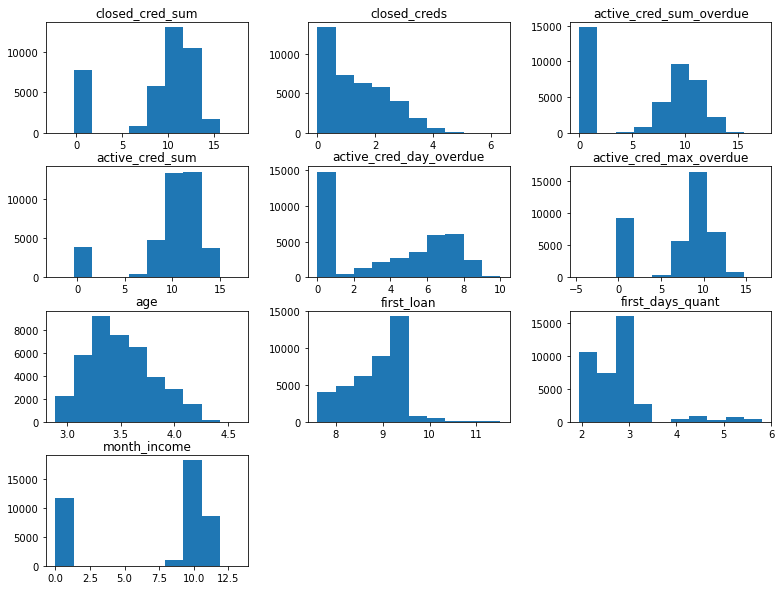

In [32]:
cont_vars.hist(figsize=(13, 10), grid=0)
plt.show()

Распределения не стали нормальными, но хотя бы приблизились к этому.

In [33]:
# процент отклоненных заявок
y.mean()

0.7962864855319256

In [34]:
n_rej = y.count() * y.mean()
n_acc = y.count() - n_rej
n_exp = y.count() / 2

chisquare([n_rej, n_acc], [n_exp, n_exp]).pvalue

0.0

Наблюдается явная несбалансированность классов, нужно учитывать это при построении моделей.

## Логистическая регрессия

In [35]:
# преобразуем переменную region в набор бинарных переменных
regions = pd.get_dummies(cat_vars.region, prefix='region')

# добавим категориальные переменные к основному набору
X_logit = cont_vars.join(regions).join(cat_vars.gender)

In [36]:
# выделим 20% в обучающую выборку
X_train, X_test, y_train, y_test = train_test_split(X_logit, y, test_size=0.2)

lg = LogisticRegression(class_weight='balanced', max_iter=2000)
lg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=2000)

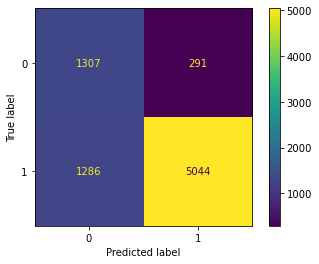

In [37]:
plot_confusion_matrix(lg, X_test, y_test)
plt.show()

На тестовой выборке модель часто допускает ошибку второго рода (False Negative) - одобряет заявки, которые должны быть отклонены.

In [38]:
lg = LogisticRegression(class_weight='balanced', max_iter=2000)

# проверим качество модели на кросс-валидации (cv=5)
print('ROC AUC:', cross_val_score(lg, X_logit, y, scoring='roc_auc').mean())
print('Precision:', cross_val_score(lg, X_logit, y, scoring='precision').mean())
print('Recall:', cross_val_score(lg, X_logit, y, scoring='recall').mean())

ROC AUC: 0.8915588708679094
Precision: 0.9460435033741252
Recall: 0.7922323561516391


Главной целью задачи является наиболее полное определение объектов первого класса (отказ по заявке) - Recall. Ведь невозвращенный кредит является большой проблемой.

Второстепенной целью будет точное определение объектов нулевого класса (одобрение заявки) - Precision. Отказывая клиентам, которые вернули бы кредит, организация теряет часть прибыли.

Построенная логистическая регрессия отлично справляется с побочной задачей, но качество выполнения основной задачи невелико. Другими словами, модель крайне редко ошибается, отклоняя заявки, но с одобрением заявок есть проблемы.

## Случайный лес

Попробуем решить задачу, используя более сложную модель. Случайный лес может находить нелинейные зависимости в данных, поэтому используем выборку без логарифмированных переменных. Тем не менее, необходимо привести переменную region к текстовому формату, иначе модель примет ее за дискретную. 

In [60]:
X_rf = df.drop(columns={'client_id', 'order_id', 'cost_all', 'loan_cost_all', 'order_date', 'expert'})
X_rf.region = X_rf.region.astype(str)

In [65]:
# отделим 20% выборки для теста
X_train, X_test, y_train, y_test = train_test_split(X_rf, y, test_size=0.2)

rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

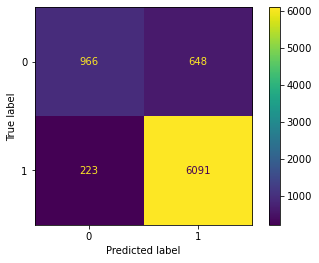

In [66]:
plot_confusion_matrix(rf, X_test, y_test)
plt.show()

На тестовой выборке случайный лес показывает себя гораздо лучше, чем логистическая регрессия.

In [67]:
sorted(list(zip(X_rf.columns, rf.feature_importances_)), key=lambda x: -x[1])

[('month_income', 0.1432931616377621),
 ('age', 0.09824573724345441),
 ('first_days_quant', 0.09426677085208589),
 ('closed_creds', 0.09342767574820768),
 ('active_cred_sum_overdue', 0.09226601129620558),
 ('first_loan', 0.09145981603097371),
 ('closed_cred_sum', 0.08862441113993562),
 ('active_cred_day_overdue', 0.08441282620340841),
 ('active_cred_sum', 0.07507985472838088),
 ('region', 0.06676125912328841),
 ('active_cred_max_overdue', 0.06119560379849495),
 ('gender', 0.010966872197802324)]

Самыми важными переменными для модели являются доход в месяц, срок выплаты кредита и возраст заемщика.

In [68]:
rf = RandomForestClassifier(class_weight='balanced')

# проверим качество модели на кросс-валидации (cv=5)
print('ROC AUC:', cross_val_score(rf, X_rf, y, scoring='roc_auc').mean())
print('Precision:', cross_val_score(rf, X_rf, y, scoring='precision').mean())
print('Recall:', cross_val_score(rf, X_rf, y, scoring='recall').mean())

ROC AUC: 0.9362111398385202
Precision: 0.9094920767116716
Recall: 0.9605882012231787


Результат можно назвать удовлетворительным: модель довольно точно определяет объекты как первого, так и нулевого классов.

Тем не менее, в кредитном скоринге важна интерпретируемость, а построенная модель слишком сложна для человеческого понимания. Возможно, имеет смысл изменить параметры - например, ограничить глубину деревьев. Это снизит точность модели, но сделает ее интерпретируемой.

In [69]:
X.region.nunique()

99

Категориальная переменная region принимает 99 значений, что сильно усложняет решающие деревья. Логичным решением будет использование отдельной модели для каждого из регионов.